# Exercise 1

*Coding:* Simulate a **FrugalGPT cascade**. Assume you have two models: A (cheap, 80% accuracy) and B (expensive, 90% accuracy). Define a simple confidence heuristic for model A (e.g. length of answer or presence of a certain keyword). Implement a policy that calls A, checks confidence; if confident, use A’s answer, if not, call B. Generate a dataset of queries with “ground truth” answers and simulate the cascade, measuring overall accuracy and cost. Compare this to always using B and always using A. Show how varying the confidence threshold produces a **Pareto curve of cost vs. accuracy**.

## Solution

Baselines:
nano only -> acc=0.770, cost=$0.000061, latency=4.90s
mini only -> acc=0.885, cost=$0.000243, latency=12.88s
Cascade (selected thresholds):
 threshold  accuracy  avg_cost  avg_latency_s  nano_accept_rate
       0.0     0.770  0.000061       4.899138             1.000
       0.5     0.885  0.000210      13.505595             0.470
       1.0     0.885  0.000301      17.700875             0.015


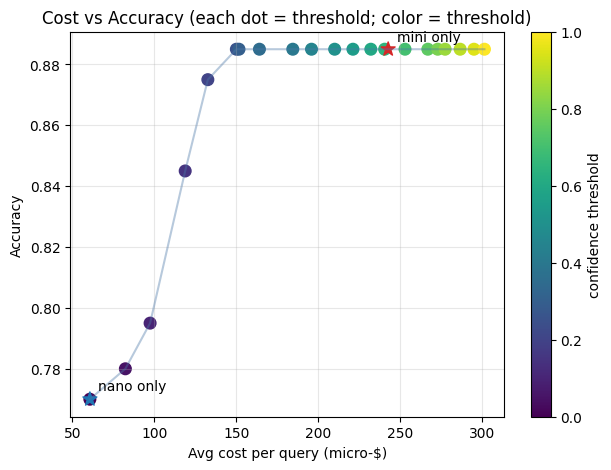

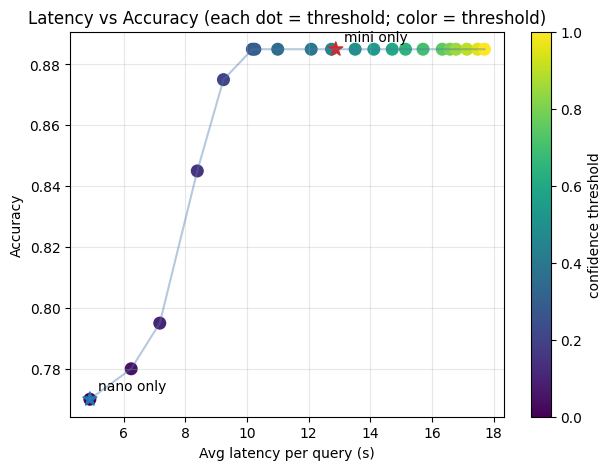

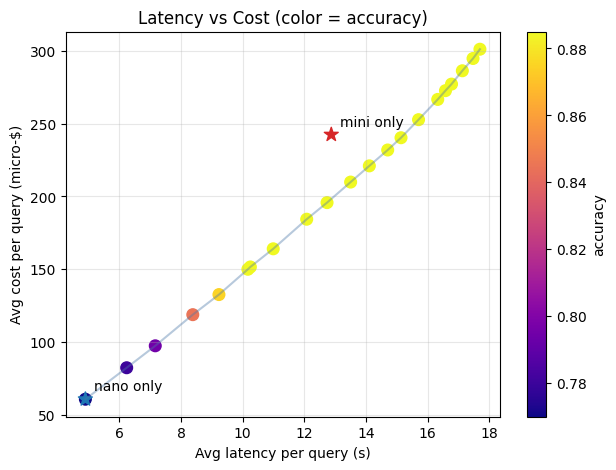

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(7)
N = 200

# OpenRouter pricing (USD per 1M tokens), base latency (s), and throughput (tokens/s).
pricing = {
    "nano": {"in": 0.10, "out": 0.40},
    "mini": {"in": 0.40, "out": 1.60},
}
base_latency_s = {"nano": 0.49, "mini": 0.51}
throughput_tps = {"nano": 77.81, "mini": 27.74}

# Synthetic dataset: prompt length drives difficulty and confidence.
prompt_tokens = rng.integers(50, 450, size=N)
completion_tokens = rng.integers(20, 150, size=N)
total_tokens = prompt_tokens + completion_tokens

labels = rng.integers(0, 2, size=N)

length_norm = (prompt_tokens - prompt_tokens.min()) / (prompt_tokens.max() - prompt_tokens.min())
difficulty = length_norm  # longer prompts are harder in this toy setup
confidence = np.clip(1 - length_norm + rng.normal(0, 0.05, size=N), 0, 1)

acc_nano, acc_mini = 0.80, 0.90

correct_nano = difficulty < acc_nano
correct_mini = difficulty < acc_mini

pred_nano = np.where(correct_nano, labels, 1 - labels)
pred_mini = np.where(correct_mini, labels, 1 - labels)

def cost_per_query(model):
    p = pricing[model]
    return (prompt_tokens * p["in"] + completion_tokens * p["out"]) / 1_000_000


def latency_per_query(model):
    return base_latency_s[model] + total_tokens / throughput_tps[model]

cost_nano = cost_per_query("nano")
cost_mini = cost_per_query("mini")

latency_nano = latency_per_query("nano")
latency_mini = latency_per_query("mini")

def run_cascade(threshold):
    use_nano = confidence >= threshold
    pred = np.where(use_nano, pred_nano, pred_mini)
    accuracy = (pred == labels).mean()
    avg_cost = (cost_nano + (~use_nano) * cost_mini).mean()
    avg_latency = (latency_nano + (~use_nano) * latency_mini).mean()
    use_nano_rate = use_nano.mean()
    return accuracy, avg_cost, avg_latency, use_nano_rate

thresholds = np.linspace(0, 1, 21)
rows = []
for t in thresholds:
    acc, avg_cost, avg_latency, use_nano_rate = run_cascade(t)
    rows.append({
        "threshold": round(float(t), 2),
        "accuracy": acc,
        "avg_cost": avg_cost,
        "avg_latency_s": avg_latency,
        "nano_accept_rate": use_nano_rate,
    })

results = pd.DataFrame(rows)

nano_acc = correct_nano.mean()
mini_acc = correct_mini.mean()
nano_cost = cost_nano.mean()
mini_cost = cost_mini.mean()
nano_latency = latency_nano.mean()
mini_latency = latency_mini.mean()

print("Baselines:")
print(f"nano only -> acc={nano_acc:.3f}, cost=${nano_cost:.6f}, latency={nano_latency:.2f}s")
print(f"mini only -> acc={mini_acc:.3f}, cost=${mini_cost:.6f}, latency={mini_latency:.2f}s")
print("Cascade (selected thresholds):")
print(results.loc[results["threshold"].isin([0.0, 0.5, 1.0])].to_string(index=False))

# Realized color ranges (so each colorbar starts at the minimum realized value).
threshold_c = results["threshold"].to_numpy(dtype=float)
threshold_norm = plt.Normalize(vmin=float(threshold_c.min()), vmax=float(threshold_c.max()))

accuracy_c = results["accuracy"].to_numpy(dtype=float)
accuracy_norm = plt.Normalize(vmin=float(accuracy_c.min()), vmax=float(accuracy_c.max()))

# Plot 1: cost vs accuracy (each point is a threshold).
plt.figure(figsize=(7, 5))
sc1 = plt.scatter(
    results["avg_cost"] * 1e6,
    results["accuracy"],
    c=threshold_c,
    cmap="viridis",
    s=70,
    norm=threshold_norm,
)
plt.plot(results["avg_cost"] * 1e6, results["accuracy"], color="#4c78a8", alpha=0.4)
plt.scatter(
    [nano_cost * 1e6, mini_cost * 1e6],
    [nano_acc, mini_acc],
    c=["#1f77b4", "#d62728"],
    s=110,
    marker="*",
)
plt.annotate("nano only", (nano_cost * 1e6, nano_acc), textcoords="offset points", xytext=(6, 6))
plt.annotate("mini only", (mini_cost * 1e6, mini_acc), textcoords="offset points", xytext=(6, 6))
plt.xlabel("Avg cost per query (micro-$)")
plt.ylabel("Accuracy")
plt.title("Cost vs Accuracy (each dot = threshold; color = threshold)")
plt.grid(True, alpha=0.3)
cb = plt.colorbar(sc1)
cb.set_label("confidence threshold")
plt.show()

# Plot 2: latency vs accuracy (each point is a threshold).
plt.figure(figsize=(7, 5))
sc2 = plt.scatter(
    results["avg_latency_s"],
    results["accuracy"],
    c=threshold_c,
    cmap="viridis",
    s=70,
    norm=threshold_norm,
)
plt.plot(results["avg_latency_s"], results["accuracy"], color="#4c78a8", alpha=0.4)
plt.scatter(
    [nano_latency, mini_latency],
    [nano_acc, mini_acc],
    c=["#1f77b4", "#d62728"],
    s=110,
    marker="*",
)
plt.annotate("nano only", (nano_latency, nano_acc), textcoords="offset points", xytext=(6, 6))
plt.annotate("mini only", (mini_latency, mini_acc), textcoords="offset points", xytext=(6, 6))
plt.xlabel("Avg latency per query (s)")
plt.ylabel("Accuracy")
plt.title("Latency vs Accuracy (each dot = threshold; color = threshold)")
plt.grid(True, alpha=0.3)
cb = plt.colorbar(sc2)
cb.set_label("confidence threshold")
plt.show()

# Plot 3: latency vs cost, color = accuracy.
plt.figure(figsize=(7, 5))
sc3 = plt.scatter(
    results["avg_latency_s"],
    results["avg_cost"] * 1e6,
    c=accuracy_c,
    cmap="plasma",
    s=70,
    norm=accuracy_norm,
)
plt.plot(results["avg_latency_s"], results["avg_cost"] * 1e6, color="#4c78a8", alpha=0.4)
plt.scatter(
    [nano_latency, mini_latency],
    [nano_cost * 1e6, mini_cost * 1e6],
    c=["#1f77b4", "#d62728"],
    s=110,
    marker="*",
)
plt.annotate("nano only", (nano_latency, nano_cost * 1e6), textcoords="offset points", xytext=(6, 6))
plt.annotate("mini only", (mini_latency, mini_cost * 1e6), textcoords="offset points", xytext=(6, 6))
plt.xlabel("Avg latency per query (s)")
plt.ylabel("Avg cost per query (micro-$)")
plt.title("Latency vs Cost (color = accuracy)")
plt.grid(True, alpha=0.3)
cb = plt.colorbar(sc3)
cb.set_label("accuracy")
plt.show()



# Exercise 2

Coding: Train a basic router model. Using an open dataset like LMSYS Chatbot Arena results, extract features (possibly the user query text or embedding) and labels (which model among a pair won). Train a classifier (e.g. a small BERT or even logistic regression on embedding features) to predict if a cheaper model’s output will be rated as good as GPT-5’s. Then evaluate: for new queries, use the classifier’s prediction to decide routing (cheap vs. expensive). How much cost can you cut while maintaining quality above a threshold?

## Solution

In [1]:
# Utils + data split
import pandas as pd
from sklearn.model_selection import train_test_split

DATA_PATH = "/home/luigi/howm/Programming/Onboarding/Day_9/data/chatbot_arena.parquet"
CHEAP_MODEL = "gpt-3.5-turbo"
EXPENSIVE_MODEL = "gpt-4"
RANDOM_SEED = 42

def user_context(conversation):
    if conversation is None:
        return ""
    if hasattr(conversation, "tolist"):
        conversation = conversation.tolist()
    try:
        parts = [m.get("content", "").strip() for m in conversation if m.get("role") == "user"]
    except TypeError:
        return ""
    return "\n".join(p for p in parts if p)

def make_splits(df, seed):
    train_df, temp_df = train_test_split(
        df, test_size=0.2, stratify=df["winner_label"], random_state=seed
    )
    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, stratify=temp_df["winner_label"], random_state=seed
    )
    return train_df, val_df, test_df

df = pd.read_parquet(
    DATA_PATH,
    columns=["model_a", "model_b", "winner", "conversation_a", "conversation_b"],
)
pair_mask = ((df["model_a"] == CHEAP_MODEL) & (df["model_b"] == EXPENSIVE_MODEL)) | (
    (df["model_b"] == CHEAP_MODEL) & (df["model_a"] == EXPENSIVE_MODEL)
)
df = df[pair_mask].copy()

records = []
for row in df.itertuples(index=False):
    cheap_is_a = row.model_a == CHEAP_MODEL
    conv = row.conversation_a if cheap_is_a else row.conversation_b
    text = user_context(conv)
    if not text:
        continue
    winner = row.winner
    cheap_side = "model_a" if cheap_is_a else "model_b"
    expensive_side = "model_b" if cheap_is_a else "model_a"
    if winner == "tie":
        winner_label = "tie"
    elif winner == cheap_side:
        winner_label = "cheap"
    else:
        winner_label = "expensive"
    cheap_ok = int(winner_label in ("cheap", "tie"))
    expensive_ok = int(winner_label in ("expensive", "tie"))
    records.append((text, cheap_ok, expensive_ok, winner_label))

data = pd.DataFrame(records, columns=["text", "cheap_ok", "expensive_ok", "winner_label"])
data = data.reset_index(drop=True)

print({
    "total": len(data),
    "winner_label_counts": data["winner_label"].value_counts().to_dict(),
})


{'total': 363, 'winner_label_counts': {'expensive': 208, 'tie': 108, 'cheap': 47}}


In [2]:
# Core logic: embeddings, model, threshold search
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression

EMBED_MODEL = "ibm-granite/granite-embedding-small-english-r2"
CHEAP_COST = 1.0
EXPENSIVE_COST = 10.0
QUALITY_TARGET = 0.90
SEEDS = [42, 43, 44, 45, 46]
PLOT_SEED = SEEDS[0]

device = "cuda" if torch.cuda.is_available() else "cpu"
embedder = SentenceTransformer(EMBED_MODEL, device=device)

def embed_texts(texts, batch_size=16):
    return embedder.encode(
        texts, batch_size=batch_size, show_progress_bar=True, normalize_embeddings=True
    )

def eval_policy(probs, df, tau):
    choose_cheap = probs >= tau
    quality = np.where(choose_cheap, df["cheap_ok"].values, df["expensive_ok"].values).mean()
    cost = np.where(choose_cheap, CHEAP_COST, EXPENSIVE_COST).mean()
    cheap_rate = choose_cheap.mean()
    return quality, cost, cheap_rate

X_all = embed_texts(data["text"].tolist())

def run_seed(seed, return_curve=False):
    train_df, val_df, test_df = make_splits(data, seed)
    X_train = X_all[train_df.index.values]
    X_val = X_all[val_df.index.values]
    X_test = X_all[test_df.index.values]

    clf = LogisticRegression(max_iter=1000, n_jobs=-1)
    clf.fit(X_train, train_df["cheap_ok"].values)

    val_probs = clf.predict_proba(X_val)[:, 1]
    baseline_val = val_df["expensive_ok"].mean()
    taus = np.linspace(0, 1, 101)
    curve = []
    best = None
    for tau in taus:
        quality, cost, cheap_rate = eval_policy(val_probs, val_df, tau)
        meets = quality >= QUALITY_TARGET * baseline_val
        savings = 1 - (cost / EXPENSIVE_COST)
        curve.append((tau, quality, cost, savings, cheap_rate, meets))
        if meets and (best is None or savings > best[3]):
            best = (tau, quality, cost, savings, cheap_rate, meets)

    if best is None:
        best = max(curve, key=lambda x: x[1])

    best_tau = best[0]
    test_probs = clf.predict_proba(X_test)[:, 1]
    test_quality, test_cost, test_cheap_rate = eval_policy(test_probs, test_df, best_tau)
    baseline_test = test_df["expensive_ok"].mean()
    test_savings = 1 - (test_cost / EXPENSIVE_COST)

    result = {
        "seed": seed,
        "val_baseline_quality": float(baseline_val),
        "chosen_tau": float(best_tau),
        "test_quality": float(test_quality),
        "test_quality_vs_baseline": float(test_quality / baseline_test) if baseline_test > 0 else float('nan'),
        "test_cost_savings": float(test_savings),
        "test_cheap_rate": float(test_cheap_rate),
    }

    if return_curve:
        curve_df = pd.DataFrame(
            curve, columns=["tau", "quality", "cost", "savings", "cheap_rate", "meets"]
        )
        return result, curve_df, baseline_val, best, best_tau
    return result

results = []
curve_df = None
baseline_val = None
best = None
best_tau = None

for seed in SEEDS:
    if seed == PLOT_SEED:
        res, curve_df, baseline_val, best, best_tau = run_seed(seed, return_curve=True)
    else:
        res = run_seed(seed)
    results.append(res)

results_df = pd.DataFrame(results)
summary = results_df.drop(columns=["seed"]).agg(["mean", "std"])
print(results_df)
print(summary)


/home/luigi/howm/Programming/Onboarding/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 23/23 [00:57<00:00,  2.50s/it]
/home/luigi/howm/Programming/Onboarding/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/home/luigi/howm/Programming/Onboarding/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
/home/luigi/howm/Programming/Onboarding/.venv/lib/python3.11/site-packages/skle

   seed  val_baseline_quality  chosen_tau  test_quality  \
0    42              0.888889        0.43      0.729730   
1    43              0.888889        0.47      0.837838   
2    44              0.888889        0.46      0.729730   
3    45              0.888889        0.45      0.864865   
4    46              0.888889        0.46      0.837838   

   test_quality_vs_baseline  test_cost_savings  test_cheap_rate  
0                   0.84375           0.364865         0.405405  
1                   0.96875           0.048649         0.054054  
2                   0.84375           0.170270         0.189189  
3                   1.00000           0.121622         0.135135  
4                   0.96875           0.145946         0.162162  
      val_baseline_quality  chosen_tau  test_quality  \
mean          8.888889e-01    0.454000       0.80000   
std           1.241267e-16    0.015166       0.06509   

      test_quality_vs_baseline  test_cost_savings  test_cheap_rate  
mean       

/home/luigi/howm/Programming/Onboarding/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


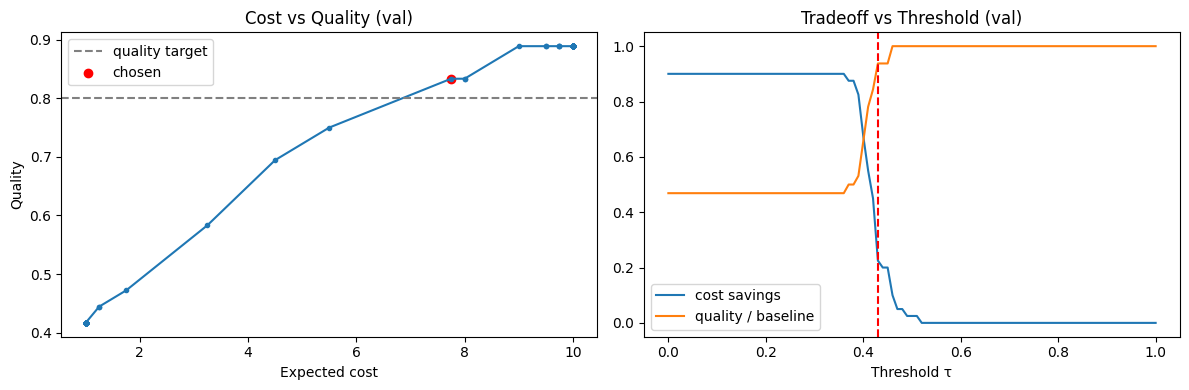

In [3]:
# Plots
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(curve_df["cost"], curve_df["quality"], marker=".")
axes[0].axhline(QUALITY_TARGET * baseline_val, color="gray", linestyle="--", label="quality target")
axes[0].scatter([best[2]], [best[1]], color="red", label="chosen")
axes[0].set_xlabel("Expected cost")
axes[0].set_ylabel("Quality")
axes[0].set_title("Cost vs Quality (val)")
axes[0].legend()

axes[1].plot(curve_df["tau"], curve_df["savings"], label="cost savings")
axes[1].plot(curve_df["tau"], curve_df["quality"] / baseline_val, label="quality / baseline")
axes[1].axvline(best_tau, color="red", linestyle="--")
axes[1].set_xlabel("Threshold τ")
axes[1].set_title("Tradeoff vs Threshold (val)")
axes[1].legend()

plt.tight_layout()


# Exercise 3

 In production, routing decisions might also consider latency. Discuss how you would extend the bandit formulation to include latency constraints. (Hint: this becomes a multi-objective problem - you might impose a penalty on using a slower model. How could you incorporate that? Perhaps as a negative reward for exceeding a latency target, or as an additional arm that is “do nothing and respond with an apology” if all models are too slow.) Outline an approach and any algorithms that could handle such constrained bandit problems.

## Solution

I would incorporate latency as an additional term in the reward function, as a normalized cost, similar to the approach used in the Nvidia paper:"ToolOrchestra: Elevating Intelligence via Efficient Model and Tool Orchestration" (https://arxiv.org/abs/2511.21689).
